# Linear Regression Starter Kit for Kaggle House Prices 

## Imports and inits

In [1]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.grid.grid_search import H2OGridSearch 
h2o.init(max_mem_size='7G') # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd

import matplotlib as plt
%matplotlib inline

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 day 0 hours 27 mins
H2O cluster version:,3.12.0.1
H2O cluster version age:,"21 days, 14 hours and 7 minutes"
H2O cluster name:,H2O_from_python_naveen_08amar
H2O cluster total nodes:,1
H2O cluster free memory:,5.585 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


## Import data

In [4]:
train = h2o.import_file('../KaggleHousePrices/train.csv')
test = h2o.import_file('../KaggleHousePrices/test.csv')

# bug fix - from Keston
dummy_col = np.random.rand(test.shape[0])
test = test.cbind(h2o.H2OFrame(dummy_col))
cols = test.columns
cols[-1] = 'SalePrice'
test.columns = cols
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 81)


#### Determine data types

In [5]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [6]:
original_nums, cats = get_type_lists()

Numeric = ['Fireplaces', 'GrLivArea', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtUnfSF', 'ScreenPorch', 'OverallCond', 'LotArea', '2ndFlrSF', 'PoolArea', 'TotRmsAbvGrd', 'OpenPorchSF', 'FullBath', 'MSSubClass', 'YearRemodAdd', 'BsmtFinSF1', '1stFlrSF', 'BsmtFullBath', 'LowQualFinSF', 'KitchenAbvGr', 'YrSold', 'LotFrontage', 'GarageYrBlt', 'OverallQual', 'MiscVal', 'EnclosedPorch', 'BedroomAbvGr', 'BsmtHalfBath', 'GarageArea', 'GarageCars', 'WoodDeckSF', 'HalfBath', '3SsnPorch', 'MoSold', 'YearBuilt', 'MasVnrArea']

Categorical = ['BsmtCond', 'Heating', 'Functional', 'GarageCond', 'PavedDrive', 'CentralAir', 'ExterQual', 'GarageType', 'BsmtFinType2', 'LandSlope', 'RoofStyle', 'LotShape', 'SaleCondition', 'MasVnrType', 'Alley', 'GarageFinish', 'GarageQual', 'Street', 'PoolQC', 'Neighborhood', 'Condition2', 'LandContour', 'Utilities', 'BsmtFinType1', 'MiscFeature', 'BsmtQual', 'HouseStyle', 'Condition1', 'Fence', 'BsmtExposure', 'Exterior1st', 'Exterior2nd', 'BldgType', 'FireplaceQu', 'Foundation'

## Split into to train and validation (before doing data prep!!!)

In [7]:
train, valid = train.split_frame([0.7], seed=12345)
print(train.shape)
print(valid.shape)

(1001, 81)
(459, 81)


## Impute numeric missing

In [8]:
# median usually better than mean
# (_ signifies temporary throw-away variable, used to suppress output)
_ = train[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = valid[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = test[['BsmtHalfBath', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea', 
          'GarageYrBlt', 'LotFrontage', 'GarageCars', 'TotalBsmtSF', 'GarageArea']].impute(method='median')

## Encode categorical vars using shrunken averages
http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps

In [9]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)

    row_val_dict[np.nan] = overall_mean # handle missing values

    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)


#### Execute encoding

In [10]:
total = len(cats)
for i, var in enumerate(cats):
    
    tr_enc, _ = target_encoder(train, test, var, 'SalePrice')
    v_enc, ts_enc = target_encoder(valid, test, var, 'SalePrice')
    
    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    valid = valid.cbind(v_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: BsmtCond (1/43) ...
Encoding: Heating (2/43) ...
Encoding: Functional (3/43) ...
Encoding: GarageCond (4/43) ...
Encoding: PavedDrive (5/43) ...
Encoding: CentralAir (6/43) ...
Encoding: ExterQual (7/43) ...
Encoding: GarageType (8/43) ...
Encoding: BsmtFinType2 (9/43) ...
Encoding: LandSlope (10/43) ...
Encoding: RoofStyle (11/43) ...
Encoding: LotShape (12/43) ...
Encoding: SaleCondition (13/43) ...
Encoding: MasVnrType (14/43) ...
Encoding: Alley (15/43) ...
Encoding: GarageFinish (16/43) ...
Encoding: GarageQual (17/43) ...
Encoding: Street (18/43) ...
Encoding: PoolQC (19/43) ...
Encoding: Neighborhood (20/43) ...
Encoding: Condition2 (21/43) ...
Encoding: LandContour (22/43) ...
Encoding: Utilities (23/43) ...
Encoding: BsmtFinType1 (24/43) ...
Encoding: MiscFeature (25/43) ...
Encoding: BsmtQual (26/43) ...
Encoding: HouseStyle (27/43) ...
Encoding: Condition1 (28/43) ...
Encoding: Fence (29/43) ...
Encoding: BsmtExposure (30/43) ...
Encoding: Exterior1st (31/43) ...
E

#### One-hot encode categorical variables

In [11]:
# one-hot encode training frame
train_cats_df = train[cats].as_data_frame()
train_cats_df_dummies = pd.get_dummies(train_cats_df)

# one-hot encode validation frame
valid_cats_df = valid[cats].as_data_frame()
valid_cats_df_dummies = pd.get_dummies(valid_cats_df)

# keep only the same new columns in the encoded new frames
# (they different b/c of different levels in variables)
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(valid_cats_df_dummies.columns))
valid_diff_cols = list(set(valid_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(valid_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in both frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# one-hot encode test frame
test_cats_df = test[cats].as_data_frame()
test_cats_df_dummies = pd.get_dummies(test_cats_df)

# keep only the same new columns in train and valid encoded frames
# (they different b/c of different levels in variables)
# remove columns in train and valid encoded frames not in encoded test frame
# remember encoded train and valid now have same columns
# so only need to check for train OR valid, not both
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(test_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in encoded train and valid frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# now remove columns in encoded test not in encoded train and valid
# (they different b/c of different levels in variables)
train_diff_cols = list(set(test_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
test_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in all encoded frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(test_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns) and all(valid_cats_df_dummies.columns == test_cats_df_dummies.columns))

# convert to h2o
train_one_hot = h2o.H2OFrame(train_cats_df_dummies.as_matrix())
train_one_hot.columns = list(train_cats_df_dummies.columns)
train = train.cbind(train_one_hot)

valid_one_hot = h2o.H2OFrame(valid_cats_df_dummies.as_matrix())
valid_one_hot.columns = list(valid_cats_df_dummies.columns)
valid = valid.cbind(valid_one_hot)

test_one_hot = h2o.H2OFrame(test_cats_df_dummies.as_matrix())
test_one_hot.columns = list(test_cats_df_dummies.columns)
test = test.cbind(test_one_hot) 

(1001, 216)
(459, 216)
True
(1001, 211)
(459, 211)
True
(1001, 211)
(459, 211)
(1459, 211)
True


#### Redefine numerics and explore

In [12]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['Fireplaces', 'Neighborhood_Blmngtn', 'Neighborhood_BrkSide', 'Exterior1st_AsbShng', 'Neighborhood_SWISU', 'FireplaceQu_Gd', 'HeatingQC_Gd', 'LotArea', 'BsmtFinType2_GLQ', 'BldgType_1Fam', 'Electrical_Tencode', 'PoolArea', 'Heating_Grav', 'Exterior2nd_HdBoard', 'LandContour_Low', 'Exterior1st_Wd Sdng', 'LotShape_Tencode', 'Neighborhood_Gilbert', 'LandSlope_Sev', 'BsmtExposure_Av', 'ExterCond_Gd', 'Neighborhood_OldTown', 'BsmtCond_Gd', 'MSZoning_RL', 'Street_Tencode', 'PavedDrive_N', 'KitchenAbvGr', 'BldgType_Tencode', 'GarageType_Tencode', 'Condition1_PosA', 'GarageYrBlt', 'Electrical_FuseP', 'PavedDrive_Y', 'LotShape_Reg', 'MiscVal', 'Exterior1st_HdBoard', 'RoofMatl_Tar&Grv', 'FireplaceQu_Po', 'Neighborhood_Edwards', 'BsmtFinType1_Rec', 'HouseStyle_SFoyer', 'Exterior1st_VinylSd', 'Heating_Tencode', 'GarageCars', 'Fence_MnPrv', 'GarageQual_TA', 'Condition1_RRAn', 'Alley_Grvl', 'BsmtFinType2_LwQ', 'Fence_GdPrv', 'MSZoning_RH', 'ExterQual_TA', 'Foundation_Stone', 'HalfBath', '

In [13]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
valid[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1001
Cols:290




,Fireplaces,Neighborhood_Blmngtn,Neighborhood_BrkSide,Exterior1st_AsbShng,Neighborhood_SWISU,FireplaceQu_Gd,HeatingQC_Gd,LotArea,BsmtFinType2_GLQ,BldgType_1Fam,Electrical_Tencode,PoolArea,Heating_Grav,Exterior2nd_HdBoard,LandContour_Low,Exterior1st_Wd Sdng,LotShape_Tencode,Neighborhood_Gilbert,LandSlope_Sev,BsmtExposure_Av,ExterCond_Gd,Neighborhood_OldTown,BsmtCond_Gd,MSZoning_RL,Street_Tencode,PavedDrive_N,KitchenAbvGr,BldgType_Tencode,GarageType_Tencode,Condition1_PosA,GarageYrBlt,Electrical_FuseP,PavedDrive_Y,LotShape_Reg,MiscVal,Exterior1st_HdBoard,RoofMatl_Tar&Grv,FireplaceQu_Po,Neighborhood_Edwards,BsmtFinType1_Rec,HouseStyle_SFoyer,Exterior1st_VinylSd,Heating_Tencode,GarageCars,Fence_MnPrv,GarageQual_TA,Condition1_RRAn,Alley_Grvl,BsmtFinType2_LwQ,Fence_GdPrv,MSZoning_RH,ExterQual_TA,Foundation_Stone,HalfBath,Neighborhood_MeadowV,YrSold,HouseStyle_2Story,Neighborhood_ClearCr,GarageType_Detchd,YearBuilt,KitchenQual_Tencode,RoofStyle_Tencode,BsmtFinType1_ALQ,GarageCond_Ex,GarageCond_Fa,Exterior1st_BrkComm,LandSlope_Tencode,PoolQC_Tencode,Exterior2nd_Plywood,LotFrontage,SaleType_New,Electrical_FuseA,LandContour_Bnk,GrLivArea,ExterQual_Tencode,Exterior1st_BrkFace,BsmtFinSF2,RoofMatl_Tencode,RoofStyle_Flat,Street_Grvl,ScreenPorch,HouseStyle_Tencode,GarageArea,Utilities_AllPub,MasVnrType_Tencode,BsmtQual_Ex,Neighborhood_Timber,BsmtCond_Po,2ndFlrSF,Exterior2nd_VinylSd,RoofStyle_Shed,SaleType_CWD,Electrical_SBrkr,ExterCond_TA,Exterior2nd_BrkFace,Exterior2nd_Stone,Condition1_Feedr,Exterior2nd_Wd Sdng,Functional_Mod,OverallQual,BsmtFinType2_Unf,SaleType_ConLD,LotConfig_Tencode,1stFlrSF,MiscFeature_Gar2,BsmtFullBath,SaleCondition_Family,Electrical_FuseF,Condition1_Norm,MiscFeature_Tencode,GarageType_2Types,FireplaceQu_Ex,Foundation_BrkTil,KitchenQual_Gd,GarageType_Attchd,YearRemodAdd,SaleType_ConLI,SaleType_COD,BldgType_Twnhs,BsmtFinType2_BLQ,BsmtExposure_Mn,Exterior2nd_Stucco,FireplaceQu_TA,Functional_Maj2,BedroomAbvGr,GarageType_BuiltIn,SaleCondition_Tencode,LandSlope_Gtl,Exterior2nd_AsbShng,Neighborhood_NAmes,Neighborhood_Veenker,FullBath,Exterior2nd_Wd Shng,Street_Pave,GarageCond_TA,GarageCond_Tencode,MasVnrType_BrkCmn,Condition1_Artery,GarageFinish_Tencode,KitchenQual_TA,Condition1_Tencode,LotShape_IR1,Exterior2nd_Tencode,GarageQual_Fa,ExterQual_Ex,Exterior1st_CemntBd,BsmtQual_Gd,Neighborhood_NoRidge,SaleType_Tencode,GarageType_Basment,FireplaceQu_Tencode,LotConfig_CulDSac,SaleType_ConLw,Condition2_Artery,Neighborhood_BrDale,Foundation_Tencode,BsmtExposure_Gd,CentralAir_N,MSSubClass,TotalBsmtSF,BsmtUnfSF,SaleCondition_Alloca,MasVnrType_None,KitchenQual_Fa,OverallCond,GarageFinish_RFn,Condition1_PosN,HouseStyle_SLvl,RoofStyle_Gambrel,PavedDrive_Tencode,LotConfig_Inside,TotRmsAbvGrd,GarageType_CarPort,RoofMatl_WdShngl,OpenPorchSF,BsmtFinType2_ALQ,LandContour_Lvl,Fence_MnWw,Exterior2nd_CmentBd,Exterior1st_Stucco,BsmtExposure_No,MasVnrType_BrkFace,Exterior2nd_MetalSd,HouseStyle_1.5Unf,GarageCond_Po,KitchenQual_Ex,SaleType_WD,GarageQual_Gd,LandContour_HLS,Neighborhood_IDOTRR,BsmtQual_Tencode,HeatingQC_Tencode,Neighborhood_Mitchel,BsmtQual_Fa,Neighborhood_NPkVill,MSZoning_RM,EnclosedPorch,MiscFeature_Othr,BsmtFinType1_GLQ,BsmtQual_TA,LotShape_IR3,BldgType_2fmCon,GarageCond_Gd,HouseStyle_1.5Fin,Heating_GasW,Functional_Tencode,Utilities_Tencode,Functional_Typ,WoodDeckSF,BsmtFinType2_Tencode,Neighborhood_NridgHt,Exterior1st_Plywood,SaleType_Oth,GarageQual_Po,Neighborhood_Crawfor,BsmtFinType1_LwQ,Condition2_Tencode,Exterior1st_MetalSd,GarageFinish_Fin,LandContour_Tencode,HeatingQC_TA,BsmtFinType1_Unf,Exterior2nd_Brk Cmn,Exterior1st_Tencode,PavedDrive_P,GarageQual_Tencode,LandSlope_Mod,Neighborhood_Tencode,MSZoning_C (all),MasVnrArea,Exterior1st_WdShing,FireplaceQu_Fa,Exterior2nd_AsphShn,HeatingQC_Ex,ExterCond_Tencode,HeatingQC_Fa,Neighborhood_NWAmes,BldgType_Duplex,CentralAir_Y,Foundation_Slab,Condition2_Norm,LotConfig_FR2,MiscFeature_Shed,Fence_GdWo,LotConfig_Corner,ExterCond_Fa,LowQualFinSF,BsmtCond_Tencode,BsmtFinType2_Rec,Functional

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:459
Cols:290




,Fireplaces,Neighborhood_Blmngtn,Neighborhood_BrkSide,Exterior1st_AsbShng,Neighborhood_SWISU,FireplaceQu_Gd,HeatingQC_Gd,LotArea,BsmtFinType2_GLQ,BldgType_1Fam,Electrical_Tencode,PoolArea,Heating_Grav,Exterior2nd_HdBoard,LandContour_Low,Exterior1st_Wd Sdng,LotShape_Tencode,Neighborhood_Gilbert,LandSlope_Sev,BsmtExposure_Av,ExterCond_Gd,Neighborhood_OldTown,BsmtCond_Gd,MSZoning_RL,Street_Tencode,PavedDrive_N,KitchenAbvGr,BldgType_Tencode,GarageType_Tencode,Condition1_PosA,GarageYrBlt,Electrical_FuseP,PavedDrive_Y,LotShape_Reg,MiscVal,Exterior1st_HdBoard,RoofMatl_Tar&Grv,FireplaceQu_Po,Neighborhood_Edwards,BsmtFinType1_Rec,HouseStyle_SFoyer,Exterior1st_VinylSd,Heating_Tencode,GarageCars,Fence_MnPrv,GarageQual_TA,Condition1_RRAn,Alley_Grvl,BsmtFinType2_LwQ,Fence_GdPrv,MSZoning_RH,ExterQual_TA,Foundation_Stone,HalfBath,Neighborhood_MeadowV,YrSold,HouseStyle_2Story,Neighborhood_ClearCr,GarageType_Detchd,YearBuilt,KitchenQual_Tencode,RoofStyle_Tencode,BsmtFinType1_ALQ,GarageCond_Ex,GarageCond_Fa,Exterior1st_BrkComm,LandSlope_Tencode,PoolQC_Tencode,Exterior2nd_Plywood,LotFrontage,SaleType_New,Electrical_FuseA,LandContour_Bnk,GrLivArea,ExterQual_Tencode,Exterior1st_BrkFace,BsmtFinSF2,RoofMatl_Tencode,RoofStyle_Flat,Street_Grvl,ScreenPorch,HouseStyle_Tencode,GarageArea,Utilities_AllPub,MasVnrType_Tencode,BsmtQual_Ex,Neighborhood_Timber,BsmtCond_Po,2ndFlrSF,Exterior2nd_VinylSd,RoofStyle_Shed,SaleType_CWD,Electrical_SBrkr,ExterCond_TA,Exterior2nd_BrkFace,Exterior2nd_Stone,Condition1_Feedr,Exterior2nd_Wd Sdng,Functional_Mod,OverallQual,BsmtFinType2_Unf,SaleType_ConLD,LotConfig_Tencode,1stFlrSF,MiscFeature_Gar2,BsmtFullBath,SaleCondition_Family,Electrical_FuseF,Condition1_Norm,MiscFeature_Tencode,GarageType_2Types,FireplaceQu_Ex,Foundation_BrkTil,KitchenQual_Gd,GarageType_Attchd,YearRemodAdd,SaleType_ConLI,SaleType_COD,BldgType_Twnhs,BsmtFinType2_BLQ,BsmtExposure_Mn,Exterior2nd_Stucco,FireplaceQu_TA,Functional_Maj2,BedroomAbvGr,GarageType_BuiltIn,SaleCondition_Tencode,LandSlope_Gtl,Exterior2nd_AsbShng,Neighborhood_NAmes,Neighborhood_Veenker,FullBath,Exterior2nd_Wd Shng,Street_Pave,GarageCond_TA,GarageCond_Tencode,MasVnrType_BrkCmn,Condition1_Artery,GarageFinish_Tencode,KitchenQual_TA,Condition1_Tencode,LotShape_IR1,Exterior2nd_Tencode,GarageQual_Fa,ExterQual_Ex,Exterior1st_CemntBd,BsmtQual_Gd,Neighborhood_NoRidge,SaleType_Tencode,GarageType_Basment,FireplaceQu_Tencode,LotConfig_CulDSac,SaleType_ConLw,Condition2_Artery,Neighborhood_BrDale,Foundation_Tencode,BsmtExposure_Gd,CentralAir_N,MSSubClass,TotalBsmtSF,BsmtUnfSF,SaleCondition_Alloca,MasVnrType_None,KitchenQual_Fa,OverallCond,GarageFinish_RFn,Condition1_PosN,HouseStyle_SLvl,RoofStyle_Gambrel,PavedDrive_Tencode,LotConfig_Inside,TotRmsAbvGrd,GarageType_CarPort,RoofMatl_WdShngl,OpenPorchSF,BsmtFinType2_ALQ,LandContour_Lvl,Fence_MnWw,Exterior2nd_CmentBd,Exterior1st_Stucco,BsmtExposure_No,MasVnrType_BrkFace,Exterior2nd_MetalSd,HouseStyle_1.5Unf,GarageCond_Po,KitchenQual_Ex,SaleType_WD,GarageQual_Gd,LandContour_HLS,Neighborhood_IDOTRR,BsmtQual_Tencode,HeatingQC_Tencode,Neighborhood_Mitchel,BsmtQual_Fa,Neighborhood_NPkVill,MSZoning_RM,EnclosedPorch,MiscFeature_Othr,BsmtFinType1_GLQ,BsmtQual_TA,LotShape_IR3,BldgType_2fmCon,GarageCond_Gd,HouseStyle_1.5Fin,Heating_GasW,Functional_Tencode,Utilities_Tencode,Functional_Typ,WoodDeckSF,BsmtFinType2_Tencode,Neighborhood_NridgHt,Exterior1st_Plywood,SaleType_Oth,GarageQual_Po,Neighborhood_Crawfor,BsmtFinType1_LwQ,Condition2_Tencode,Exterior1st_MetalSd,GarageFinish_Fin,LandContour_Tencode,HeatingQC_TA,BsmtFinType1_Unf,Exterior2nd_Brk Cmn,Exterior1st_Tencode,PavedDrive_P,GarageQual_Tencode,LandSlope_Mod,Neighborhood_Tencode,MSZoning_C (all),MasVnrArea,Exterior1st_WdShing,FireplaceQu_Fa,Exterior2nd_AsphShn,HeatingQC_Ex,ExterCond_Tencode,HeatingQC_Fa,Neighborhood_NWAmes,BldgType_Duplex,CentralAir_Y,Foundation_Slab,Condition2_Norm,LotConfig_FR2,MiscFeature_Shed,Fence_GdWo,LotConfig_Corner,ExterCond_Fa,LowQualFinSF,BsmtCond_Tencode,BsmtFinType2_Rec,Functional

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:290




,Fireplaces,Neighborhood_Blmngtn,Neighborhood_BrkSide,Exterior1st_AsbShng,Neighborhood_SWISU,FireplaceQu_Gd,HeatingQC_Gd,LotArea,BsmtFinType2_GLQ,BldgType_1Fam,Electrical_Tencode,PoolArea,Heating_Grav,Exterior2nd_HdBoard,LandContour_Low,Exterior1st_Wd Sdng,LotShape_Tencode,Neighborhood_Gilbert,LandSlope_Sev,BsmtExposure_Av,ExterCond_Gd,Neighborhood_OldTown,BsmtCond_Gd,MSZoning_RL,Street_Tencode,PavedDrive_N,KitchenAbvGr,BldgType_Tencode,GarageType_Tencode,Condition1_PosA,GarageYrBlt,Electrical_FuseP,PavedDrive_Y,LotShape_Reg,MiscVal,Exterior1st_HdBoard,RoofMatl_Tar&Grv,FireplaceQu_Po,Neighborhood_Edwards,BsmtFinType1_Rec,HouseStyle_SFoyer,Exterior1st_VinylSd,Heating_Tencode,GarageCars,Fence_MnPrv,GarageQual_TA,Condition1_RRAn,Alley_Grvl,BsmtFinType2_LwQ,Fence_GdPrv,MSZoning_RH,ExterQual_TA,Foundation_Stone,HalfBath,Neighborhood_MeadowV,YrSold,HouseStyle_2Story,Neighborhood_ClearCr,GarageType_Detchd,YearBuilt,KitchenQual_Tencode,RoofStyle_Tencode,BsmtFinType1_ALQ,GarageCond_Ex,GarageCond_Fa,Exterior1st_BrkComm,LandSlope_Tencode,PoolQC_Tencode,Exterior2nd_Plywood,LotFrontage,SaleType_New,Electrical_FuseA,LandContour_Bnk,GrLivArea,ExterQual_Tencode,Exterior1st_BrkFace,BsmtFinSF2,RoofMatl_Tencode,RoofStyle_Flat,Street_Grvl,ScreenPorch,HouseStyle_Tencode,GarageArea,Utilities_AllPub,MasVnrType_Tencode,BsmtQual_Ex,Neighborhood_Timber,BsmtCond_Po,2ndFlrSF,Exterior2nd_VinylSd,RoofStyle_Shed,SaleType_CWD,Electrical_SBrkr,ExterCond_TA,Exterior2nd_BrkFace,Exterior2nd_Stone,Condition1_Feedr,Exterior2nd_Wd Sdng,Functional_Mod,OverallQual,BsmtFinType2_Unf,SaleType_ConLD,LotConfig_Tencode,1stFlrSF,MiscFeature_Gar2,BsmtFullBath,SaleCondition_Family,Electrical_FuseF,Condition1_Norm,MiscFeature_Tencode,GarageType_2Types,FireplaceQu_Ex,Foundation_BrkTil,KitchenQual_Gd,GarageType_Attchd,YearRemodAdd,SaleType_ConLI,SaleType_COD,BldgType_Twnhs,BsmtFinType2_BLQ,BsmtExposure_Mn,Exterior2nd_Stucco,FireplaceQu_TA,Functional_Maj2,BedroomAbvGr,GarageType_BuiltIn,SaleCondition_Tencode,LandSlope_Gtl,Exterior2nd_AsbShng,Neighborhood_NAmes,Neighborhood_Veenker,FullBath,Exterior2nd_Wd Shng,Street_Pave,GarageCond_TA,GarageCond_Tencode,MasVnrType_BrkCmn,Condition1_Artery,GarageFinish_Tencode,KitchenQual_TA,Condition1_Tencode,LotShape_IR1,Exterior2nd_Tencode,GarageQual_Fa,ExterQual_Ex,Exterior1st_CemntBd,BsmtQual_Gd,Neighborhood_NoRidge,SaleType_Tencode,GarageType_Basment,FireplaceQu_Tencode,LotConfig_CulDSac,SaleType_ConLw,Condition2_Artery,Neighborhood_BrDale,Foundation_Tencode,BsmtExposure_Gd,CentralAir_N,MSSubClass,TotalBsmtSF,BsmtUnfSF,SaleCondition_Alloca,MasVnrType_None,KitchenQual_Fa,OverallCond,GarageFinish_RFn,Condition1_PosN,HouseStyle_SLvl,RoofStyle_Gambrel,PavedDrive_Tencode,LotConfig_Inside,TotRmsAbvGrd,GarageType_CarPort,RoofMatl_WdShngl,OpenPorchSF,BsmtFinType2_ALQ,LandContour_Lvl,Fence_MnWw,Exterior2nd_CmentBd,Exterior1st_Stucco,BsmtExposure_No,MasVnrType_BrkFace,Exterior2nd_MetalSd,HouseStyle_1.5Unf,GarageCond_Po,KitchenQual_Ex,SaleType_WD,GarageQual_Gd,LandContour_HLS,Neighborhood_IDOTRR,BsmtQual_Tencode,HeatingQC_Tencode,Neighborhood_Mitchel,BsmtQual_Fa,Neighborhood_NPkVill,MSZoning_RM,EnclosedPorch,MiscFeature_Othr,BsmtFinType1_GLQ,BsmtQual_TA,LotShape_IR3,BldgType_2fmCon,GarageCond_Gd,HouseStyle_1.5Fin,Heating_GasW,Functional_Tencode,Utilities_Tencode,Functional_Typ,WoodDeckSF,BsmtFinType2_Tencode,Neighborhood_NridgHt,Exterior1st_Plywood,SaleType_Oth,GarageQual_Po,Neighborhood_Crawfor,BsmtFinType1_LwQ,Condition2_Tencode,Exterior1st_MetalSd,GarageFinish_Fin,LandContour_Tencode,HeatingQC_TA,BsmtFinType1_Unf,Exterior2nd_Brk Cmn,Exterior1st_Tencode,PavedDrive_P,GarageQual_Tencode,LandSlope_Mod,Neighborhood_Tencode,MSZoning_C (all),MasVnrArea,Exterior1st_WdShing,FireplaceQu_Fa,Exterior2nd_AsphShn,HeatingQC_Ex,ExterCond_Tencode,HeatingQC_Fa,Neighborhood_NWAmes,BldgType_Duplex,CentralAir_Y,Foundation_Slab,Condition2_Norm,LotConfig_FR2,MiscFeature_Shed,Fence_GdWo,LotConfig_Corner,ExterCond_Fa,LowQualFinSF,BsmtCond_Tencode,BsmtFinType2_Rec,Functional

In [14]:
# Check Neighborhood_Tencode

print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(valid, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   152080
# NAmes   152080
# Gilbert 191808
# Gilbert 191808
# StoneBr 288359

Neighborhood,Neighborhood_Tencode
NAmes,152080
NAmes,152080
Gilbert,191808
Gilbert,191808
StoneBr,288359



{nan: 178193.49673202613, 'Edwards': 126241.13989441929, 'StoneBr': 288359.0245098039, 'Blmngtn': 210845.6545098039, 'BrkSide': 129965.77450980392, 'Somerst': 227656.9671023965, 'OldTown': 139863.03613771088, 'Timber': 260109.74673202613, 'Gilbert': 191808.0596949891, 'SawyerW': 189097.7776348039, 'Veenker': 243734.02450980392, 'IDOTRR': 112866.71681749621, 'Sawyer': 143162.40700980392, 'SWISU': 156269.02450980392, 'Crawfor': 216008.84593837534, 'CollgCr': 190019.77971813726, 'Mitchel': 169316.52450980392, 'NAmes': 152080.32258672698, 'BrDale': 116064.02450980392, 'ClearCr': 207949.02450980392, 'NoRidge': 273948.2552790347, 'NPkVill': 147641.52450980392, 'NWAmes': 184610.14950980392, 'NridgHt': 284073.1545098039, 'MeadowV': 113131.52450980392}


## Create combination features

In [15]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [16]:
train, _ = feature_combiner(train, test, encoded_nums)
valid, test = feature_combiner(valid, test, encoded_nums)

Combining: Fireplaces (1/290) ...
Combining: Neighborhood_Blmngtn (2/290) ...
Combining: Neighborhood_BrkSide (3/290) ...
Combining: Exterior1st_AsbShng (4/290) ...
Combining: Neighborhood_SWISU (5/290) ...
Combining: FireplaceQu_Gd (6/290) ...
Combining: HeatingQC_Gd (7/290) ...
Combining: LotArea (8/290) ...
Combining: BsmtFinType2_GLQ (9/290) ...
Combining: BldgType_1Fam (10/290) ...
Combining: Electrical_Tencode (11/290) ...
Combining: PoolArea (12/290) ...
Combining: Heating_Grav (13/290) ...
Combining: Exterior2nd_HdBoard (14/290) ...
Combining: LandContour_Low (15/290) ...
Combining: Exterior1st_Wd Sdng (16/290) ...
Combining: LotShape_Tencode (17/290) ...
Combining: Neighborhood_Gilbert (18/290) ...
Combining: LandSlope_Sev (19/290) ...
Combining: BsmtExposure_Av (20/290) ...
Combining: ExterCond_Gd (21/290) ...
Combining: Neighborhood_OldTown (22/290) ...
Combining: BsmtCond_Gd (23/290) ...
Combining: MSZoning_RL (24/290) ...
Combining: Street_Tencode (25/290) ...
Combining: P

#### Redefine numerics and explore

In [17]:
encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['MiscFeature_Tencode|CentralAir_Tencode', 'HouseStyle_1.5Unf|ExterCond_Fa', 'PavedDrive_N|HouseStyle_Tencode', 'Street_Pave|BsmtFinType1_LwQ', 'Exterior2nd_MetalSd|MSZoning_RM', 'HouseStyle_Tencode|GarageCond_Gd', 'MiscVal|MasVnrType_Tencode', 'Condition1_RRAn|SaleType_ConLD', 'BsmtExposure_Av|MasVnrType_None', 'Neighborhood_Edwards|HouseStyle_1.5Unf', 'Exterior2nd_Plywood|ExterCond_Tencode', 'MSZoning_RH|Neighborhood_NridgHt', 'PoolArea|SaleType_COD', 'BsmtFinType1_Tencode|RoofStyle_Hip', 'BldgType_1Fam|GarageQual_Po', 'Utilities_AllPub|LandSlope_Mod', 'SaleType_Tencode|Condition2_Tencode', 'Condition1_Tencode|MoSold', 'Electrical_FuseF|Neighborhood_NridgHt', 'BsmtExposure_Gd|MSZoning_FV', 'FireplaceQu_Tencode|Alley_Pave', 'Exterior1st_HdBoard|Foundation_Tencode', 'Neighborhood_OldTown|Street_Grvl', 'GarageQual_TA|GarageCond_TA', 'Neighborhood_SWISU|GarageArea', 'ExterCond_Gd|GarageFinish_Unf', 'GarageQual_Gd|MiscFeature_Shed', 'Fireplaces|Functional_Typ', 'ExterQual_Tencod

In [18]:
# check number of created variables is correct
# 1 id column, 290)) combined variables
print(train.shape == (1001, sum(range(1, 290), (290 + 43 + 1 + 1))))
print(train.shape)
print(test.shape == (1459, sum(range(1, 290), (290 + 43 + 1 + 1))))
print(test.shape)

True
(1001, 42240)
True
(1459, 42240)


In [19]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

GarageCond_Ex,GarageQual_Gd,GarageCond_Ex|GarageQual_Gd
0,0,0


GarageCond_Ex,GarageQual_Gd,GarageCond_Ex|GarageQual_Gd
0,0,0



0.0
0.0


## Train models

In [20]:
h2o.show_progress()                                          # turn on progress bars

SalePrice
12.2477
12.109
12.3172


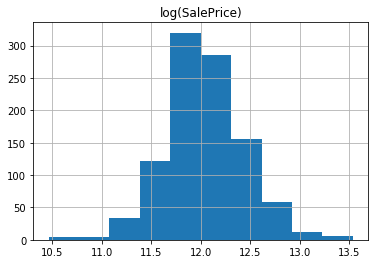

In [21]:
# Check log transform - looks good
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

#### Split training data

In [22]:
half_train, other_half_train = train.split_frame([0.5], seed=12345)
half_valid, other_half_valid = valid.split_frame([0.5], seed=12345)
print(half_train.shape)
print(half_valid.shape)
print(other_half_train.shape)
print(other_half_valid.shape)
# no idea why this works better, but it does ... 
# could be a lucky split that happens to be more representative of test data
# could be that it just prevents overfitting

(504, 42240)
(230, 42240)
(497, 42240)
(229, 42240)


#### Define model with grid search function

In [23]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best


#### Function to generate submission file

In [24]:
import re
import time

def gen_submission(model, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param model: Model with which to score test data.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(model.predict(test).exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)


#### Simple function to average predictions

In [25]:
import os

def pred_blender(dir_, files):
    
    """ Performs simple blending of prediction files. 
    
    :param dir_: Directory in which files to be read are stored.
    :param files: List of prediction files to be blended.
    
    """
    
    # read predictions in files list and cbind
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(dir_ + os.sep + file).drop('SalePrice', axis=1)
        col = pd.read_csv(dir_ + os.sep + file).drop('Id', axis=1)
        col.columns = ['SalePrice' + str(i)]
        df = pd.concat([df, col], axis=1)
        
    # create mean prediction    
    df['mean'] = df.iloc[:, 1:].mean(axis=1)
    print(df.head())
        
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())        
        
    # write new submission file    
    df = df[['Id', 'mean']]
    df.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    df.to_csv(sub_fname, index=False)
     

#### GLM model on encoded, embedded, combined numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.01]  Grid_GLM_py_297_sid_91a5_model_python_1498583160081_2_model_0   
1    [0.99]  Grid_GLM_py_297_sid_91a5_model_python_1498583160081_2_model_3   
2    [0.25]  Grid_GLM_py_297_sid_91a5_model_python_1498583160081_2_model_1   
3     [0.5]  Grid_GLM_py_297_sid_91a5_model_python_1498583160081_2_model_2   

    residual_deviance  
0  3.4064517145729987  
1   3.601916987325899  
2  3.6662778137646175  
3    3.75886957351522  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_297_sid_91a5_model_python_1498583160081_2_model_0


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.005607440669344312
RMSE: 0.07488284629569253
MAE: 0.0582120805995651
RMSLE: 0.005795671510438734
R^2: 0.9641986482382535
Mean Residual Deviance: 0.005607440669344312
Null degrees of f

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-28 14:22:12,0.000 sec,0,.32E2,31,0.1539065,0.1482131
,2017-06-28 14:22:55,43.625 sec,0,.3E2,38,0.1488535,0.1435379
,2017-06-28 14:23:21,1 min 9.052 sec,0,.29E2,62,0.1430652,0.1382479
,2017-06-28 14:23:23,1 min 11.882 sec,0,.27E2,97,0.1361001,0.1319970
,2017-06-28 14:23:49,1 min 37.937 sec,0,.26E2,118,0.1288816,0.1255493
---,---,---,---,---,---,---,---
,2017-06-28 15:33:24,1:11:12.937,0,.4E0,1700,0.0028075,0.0156003
,2017-06-28 15:34:57,1:12:45.392,0,.38E0,1715,0.0026498,0.0157000
,2017-06-28 15:37:29,1:15:17.612,0,.36E0,1733,0.0025005,0.0158026
,2017-06-28 15:40:00,1:17:48.897,0,.35E0,1765,0.0023590,0.0159002



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.0772
12.2061,12.1794
11.6784,11.6253
11.914,11.8082
12.6758,12.4599
12.861,12.7089
12.1035,11.9737
11.2898,11.4521
11.7714,11.6798
11.5843,11.6008



glm prediction progress: |████████████████████████████████████████████████| 100%


FileNotFoundError: [Errno 2] No such file or directory: '../data/submission_Wed_Jun_28_17_29_16_2017.csv'

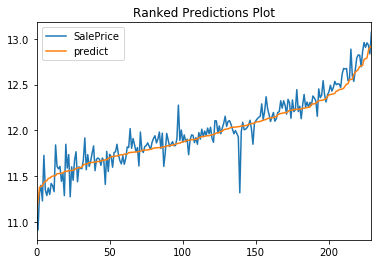

In [26]:
glm_0 = glm_grid(encoded_combined_nums, 'SalePrice', half_train, half_valid)
gen_submission(glm_0) # Valid RMSE: ~0.1217,  0.13886 on public leaderboard

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0     [0.5]  Grid_GLM_py_299_sid_bac4_model_python_1498075739069_2_model_2   
1    [0.25]  Grid_GLM_py_299_sid_bac4_model_python_1498075739069_2_model_1   
2    [0.01]  Grid_GLM_py_299_sid_bac4_model_python_1498075739069_2_model_0   
3    [0.99]  Grid_GLM_py_299_sid_bac4_model_python_1498075739069_2_model_3   

    residual_deviance  
0  3.2008581713135373  
1   3.249905138760205  
2   3.295060979047667  
3    3.30170051150327  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_299_sid_bac4_model_python_1498075739069_2_model_2


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.007098248526819206
RMSE: 0.08425110400949774
MAE: 0.06421357143316936
RMSLE: 0.006504969861086016
R^2: 0.9535341557548703
Mean Residual Deviance: 0.007098248526819206
Null degrees of 

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-21 17:03:53,0.000 sec,0,.61E0,3,0.1448747,0.1792941
,2017-06-21 17:03:54,0.654 sec,0,.58E0,5,0.1366613,0.1691453
,2017-06-21 17:03:58,4.673 sec,0,.56E0,6,0.1281002,0.1585339
,2017-06-21 17:03:58,5.459 sec,0,.53E0,9,0.1200159,0.1482836
,2017-06-21 17:03:59,6.379 sec,0,.51E0,9,0.1125339,0.1387323
---,---,---,---,---,---,---,---
,2017-06-21 17:05:12,1 min 18.872 sec,0,.77E-2,414,0.0022927,0.0156928
,2017-06-21 17:05:13,1 min 19.705 sec,0,.74E-2,427,0.0021513,0.0158566
,2017-06-21 17:05:14,1 min 21.265 sec,0,.7E-2,446,0.0020183,0.0160294
,2017-06-21 17:05:16,1 min 22.842 sec,0,.67E-2,453,0.0018912,0.0162062



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.7906,11.714
11.9117,11.9219
11.9767,11.8596
11.8451,11.7382
11.1346,11.2227
11.8845,11.8184
11.9382,11.9603
11.8565,11.7513
11.9704,11.9618
12.6667,12.549



glm prediction progress: |████████████████████████████████████████████████| 100%


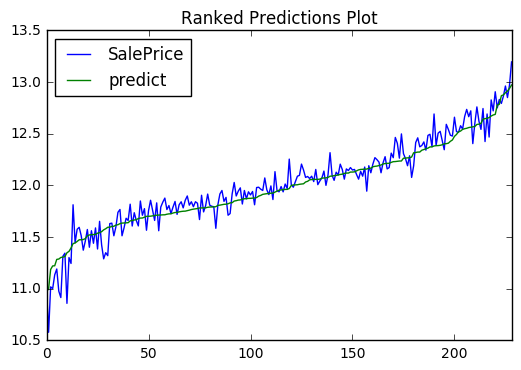

In [25]:
glm_1 = glm_grid(encoded_combined_nums, 'SalePrice', other_half_train, other_half_valid)
gen_submission(glm_1) # Valid RMSE: ~0.1196, 0.13531 on public leaderboard

#### Blend predictions

In [26]:
# pred_blender('../data/', 
#             ['submission_Wed_Jun_21_14_36_49_2017.csv',
#              'submission_Wed_Jun_21_15_15_03_2017.csv'])
# 0.13337 on public leaderboard, better than single model!

In [27]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
